In [1]:
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchsummary import summary
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
batch_size = 128
epochs = 300
train_root = 'data_set/train_set/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [18]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(25 * 25 * 32, 1000)
        self.fc1_bn = nn.BatchNorm1d(1000)
        self.fc2_mean = nn.Linear(1000, 100)
        self.fc2_logvar = nn.Linear(1000, 100)

        self.fc3 = nn.Linear(100, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        self.fc4 = nn.Linear(1000, 25 * 25 * 32)
        self.fc4_bn = nn.BatchNorm1d(25 * 25 * 32)

        self.relu = nn.ReLU()

        self.conv5 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        
    def encode(self, data):
        conv1 = self.relu(self.bn1(self.conv1(data)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3)))

        fc1 = self.relu(self.fc1_bn(self.fc1(conv4.view(-1, 25 * 25 * 32))))
        mean = self.fc2_mean(fc1)
        logvar = self.fc2_logvar(fc1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = 0.5 * torch.exp(logvar)
        z = (std.data.new(std.size()).normal_()) * std + mean
        return z
    
    def decode(self, z):
        fc3 = self.relu(self.fc3_bn(self.fc3(z)))
        fc4 = self.relu(self.fc4_bn(self.fc4(fc3)))
        conv5 = self.relu(self.bn5(self.conv5(fc4.view(-1, 32, 25, 25))))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        conv8 = self.conv8(conv7)
        return conv8.view(-1, 3, 100, 100)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

def loss_function(recon_x, x, mean, logvar):
    mse_loss = nn.MSELoss(reduction="sum")
    reconstruction_loss = mse_loss(recon_x, x)
    kld_loss = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mean**2)
    return reconstruction_loss + kld_loss

In [19]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_root, transform=transform_train),
    batch_size=batch_size, shuffle=True,drop_last = True)
fakedect = vae().to(device)
optimizer = optim.Adam(fakedect.parameters(), lr=1e-3)
print(summary(fakedect, (3, 100, 100)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 100, 100]             432
       BatchNorm2d-2         [-1, 16, 100, 100]              32
              ReLU-3         [-1, 16, 100, 100]               0
            Conv2d-4           [-1, 32, 50, 50]           4,608
       BatchNorm2d-5           [-1, 32, 50, 50]              64
              ReLU-6           [-1, 32, 50, 50]               0
            Conv2d-7           [-1, 64, 50, 50]          18,432
       BatchNorm2d-8           [-1, 64, 50, 50]             128
              ReLU-9           [-1, 64, 50, 50]               0
           Conv2d-10           [-1, 32, 25, 25]          18,432
      BatchNorm2d-11           [-1, 32, 25, 25]              64
             ReLU-12           [-1, 32, 25, 25]               0
           Linear-13                 [-1, 1000]      20,001,000
      BatchNorm1d-14                 [-

In [20]:
for epoch in range(epochs):
    fakedect.train()
    train_loss = 0
    for batch_idx, (inputs, _) in enumerate(train_loader):
        inputs = inputs.to(device)
        gen_imgs, mean, logvar = fakedect(inputs)
        loss = loss_function(gen_imgs, inputs, mean, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print('Epoch: {}  loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

Epoch: 0  loss: 3729.1848
Epoch: 1  loss: 991.6719
Epoch: 2  loss: 726.5930
Epoch: 3  loss: 618.1815
Epoch: 4  loss: 559.7879
Epoch: 5  loss: 516.2932
Epoch: 6  loss: 477.5292
Epoch: 7  loss: 450.3670
Epoch: 8  loss: 433.9437
Epoch: 9  loss: 410.4557
Epoch: 10  loss: 394.7322
Epoch: 11  loss: 379.4956
Epoch: 12  loss: 366.4005
Epoch: 13  loss: 356.8757
Epoch: 14  loss: 344.8038
Epoch: 15  loss: 337.8152
Epoch: 16  loss: 333.3430
Epoch: 17  loss: 324.3117
Epoch: 18  loss: 316.6438
Epoch: 19  loss: 312.3831
Epoch: 20  loss: 307.0548
Epoch: 21  loss: 304.1542
Epoch: 22  loss: 297.8999
Epoch: 23  loss: 291.8763
Epoch: 24  loss: 286.7061
Epoch: 25  loss: 282.8911
Epoch: 26  loss: 277.0304
Epoch: 27  loss: 274.0355
Epoch: 28  loss: 268.7506
Epoch: 29  loss: 271.4235
Epoch: 30  loss: 268.1030
Epoch: 31  loss: 264.3643
Epoch: 32  loss: 261.1193
Epoch: 33  loss: 259.4152
Epoch: 34  loss: 256.5180
Epoch: 35  loss: 254.4067
Epoch: 36  loss: 252.9850
Epoch: 37  loss: 249.5662
Epoch: 38  loss: 246.

In [21]:
torch.save(fakedect,'OC-FakeDect.pkl')

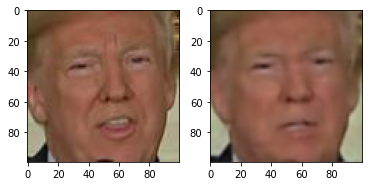

In [27]:
img = cv2.cvtColor(cv2.imread('data_set/test_set/0_0_real.jpg'), cv2.COLOR_BGR2RGB)
image = transform_test(img)
image = image.float().to(device)
fakedect.eval()
with torch.no_grad():
    x = image.view(-1,3,100,100)
    reimg = fakedect(x)
reimg = reimg[0].view(3,100,100).cpu()
reimg = 255*(reimg*0.5 + 0.5).numpy()
reimg = reimg.astype(int)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(reimg.transpose(1,2,0))

In [32]:
score = {0:[],1:[]}
for j in os.listdir('data_set/test_set/'):
    image = cv2.cvtColor(cv2.imread('data_set/test_set/'+j), cv2.COLOR_BGR2RGB)
    image = transform_test(image)
    image = image.float().to(device)
    fakedect.eval()
    with torch.no_grad():
        reimg = fakedect(image.view(-1,3,100,100))
        y = fakedect.encode(reimg[0])
    out = ((((reimg[1].cpu() - y[0].cpu())**2).sum()/1024)**0.5).item()
    if j[len(j) - 5] == 'l':
        score[1].append(out)
    else:
        score[0].append(out)

<BarContainer object of 79 artists>

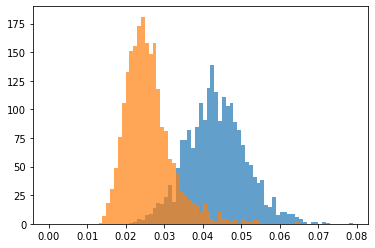

In [34]:
bins = [x*0.001 for x in range(80)]
plt.hist(score[0],bins,alpha=0.7)[2]
plt.hist(score[1],bins,alpha=0.7)[2]

In [37]:
real_score = np.array(score[1])
fake_score = np.array(score[0])
threshold = 0.034
print('When threshold is {} \nAccuracy of real pics is {:.2f}%\n\
Accuracy of fake pics is {:.2f}%\nTotal Accuracy is {:.2f}%\n'.format(
    threshold,\
    100 * ((real_score < threshold).sum() / real_score.shape[0]),\
    100 * ((fake_score > threshold).sum() / fake_score.shape[0]),\
    100 * (((real_score < threshold).sum() + (fake_score > threshold).sum())/(real_score.shape[0] + fake_score.shape[0]))))

When threshold is 0.034 
Accuracy of real pics is 90.88%
Accuracy of fake pics is 90.61%
Total Accuracy is 90.74%

